# Time Since

The recency of an event may have an impact on our forecasts. For example, if we launch an advertising campaign this week, we may expect more sales next week. But as time passes, the sales decrease again.

If there is a volcano eruption, the pollutant concentration may increase in the months after the eruption, but with time, it may go back to normal levels.

Thus, creating features that capture recency, may improve the performance of our models.

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

from statsmodels.tsa.seasonal import STL

In [30]:
# Load data

df = pd.read_csv('../Datasets/example_retail_sales.csv',
                 parse_dates=['ds'],
                 index_col=['ds'])

df.head()

,y
ds,
1992-01-01,146376
1992-02-01,147079
1992-03-01,159336
1992-04-01,163669
1992-05-01,170068


In [31]:
# Simulate advertising campaigns

res = STL(df, robust=True,).fit()

In [32]:
df['campaign'] = np.nan

df.loc[df[res.seasonal > 30000].index, 'campaign'] = df.loc[df[res.seasonal > 30000].index, 'y']

df['campaign'].sum()

8656874.0

In [33]:
df['campaign'] = df['campaign'].shift(-2)

<AxesSubplot:xlabel='ds'>

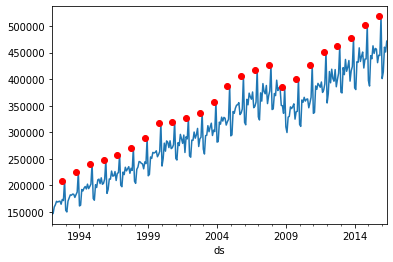

In [34]:
df['y'].plot()
df['campaign'].plot(marker='o', color='red')

## Time interval

In [35]:
tmp = pd.Series(df.index).diff()

tmp

0         NaT
1     31 days
2     29 days
3     31 days
4     30 days
        ...  
288   31 days
289   31 days
290   29 days
291   31 days
292   30 days
Name: ds, Length: 293, dtype: timedelta64[ns]

In [36]:
tmp = tmp / np.timedelta64(1,'h')

tmp

0        NaN
1      744.0
2      696.0
3      744.0
4      720.0
       ...  
288    744.0
289    744.0
290    696.0
291    744.0
292    720.0
Name: ds, Length: 293, dtype: float64

In [37]:
tmp.index = df.index

df['time_since_previous'] = tmp

df.head()

,y,campaign,time_since_previous
ds,,,
1992-01-01,146376,NaN,NaN
1992-02-01,147079,NaN,744.0
1992-03-01,159336,NaN,696.0
1992-04-01,163669,NaN,744.0
1992-05-01,170068,NaN,720.0


In [38]:
df['time_since_previous'].value_counts()

744.0    170
720.0     97
672.0     18
696.0      7
Name: time_since_previous, dtype: int64

## Time since event

In [28]:
len(df['y_season'][peaks]), len(df)

(96, 293)

In [30]:
tmp = df['y_season'][peaks]
tmp.name = ['peaks']
tmp

TypeError: Series.name must be a hashable type

In [31]:
df = df.merge(tmp, left_index=True, right_index=True, how='left')

df['line'] = 30000

df.head()

,y,time_since_previous,y_season_x,y_season_y,line
ds,,,,,
1992-01-01,146376,NaN,-18105.934264,NaN,30000
1992-02-01,147079,744.0,-19220.032341,NaN,30000
1992-03-01,159336,696.0,-5396.563294,NaN,30000
1992-04-01,163669,744.0,-885.576431,NaN,30000
1992-05-01,170068,720.0,2929.056385,2929.056385,30000


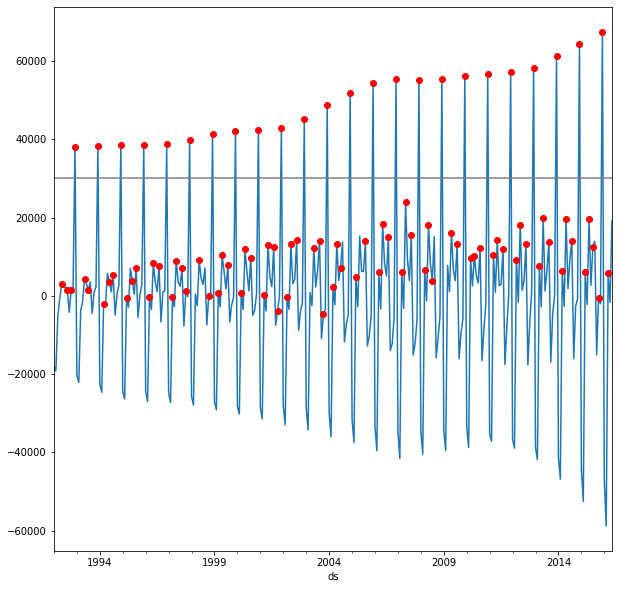

In [32]:
df['y_season_x'].plot()
df['y_season_y'].plot(marker='o', color='red')
df['line'].plot(color="gray")
plt.show()

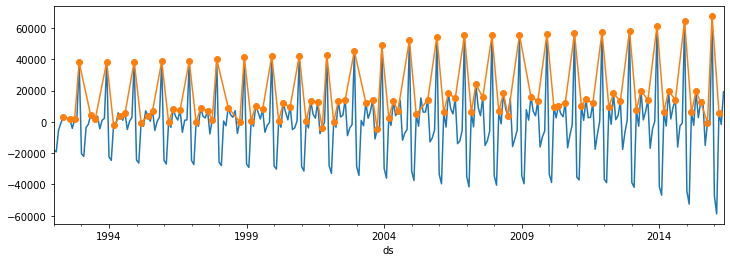

In [46]:
# plot the peaks
#---------------
plt.figure(figsize=(12, 4))

# plot the time series with the mean energy consumed per day
df['y_season_x'].plot()

df['y_season_y'][peaks].plot(marker='o')
# Overlay on top of the time series a series of red dots,
# at the location of the local maxima, using the peak variable
# for the x coordinate and the value of the peak for the y coordinate
# plt.plot(peaks, df['y'][peaks], "o", color='red')

# add a line at the baseline electricity consumption of 60 Kh
# plt.plot(np.full_like(df['y_season'], 20000), "--", color="gray")

# display the plot
plt.show()

In [13]:
# capture the series with local maxima in a pandas dataframe
# then reset index so that the month and day become part of the columns

# finally, we need to add the year, to be able to reconstitute the date
# from the existing time columns

tmp = pd.DataFrame(pollutant_pmonth[peaks]).reset_index(drop=False)
tmp['year'] = 2016
tmp.head()

,month,day,Appliances,year
0,1,14,151.388889,2016
1,1,17,142.708333,2016
2,1,20,114.444444,2016
3,1,24,150.277778,2016
4,1,26,71.319444,2016


In [14]:
# reconstitute the datetime variable

tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])

tmp.head()

,month,day,Appliances,year,date
0,1,14,151.388889,2016,2016-01-14
1,1,17,142.708333,2016,2016-01-17
2,1,20,114.444444,2016,2016-01-20
3,1,24,150.277778,2016,2016-01-24
4,1,26,71.319444,2016,2016-01-26


In [15]:
# calculate the distance, in days, between the local maxima
# we do this utilizing the dataframe with only the local maxima

tmp['peak_distance'] = tmp['date'].diff()

tmp['peak_distance'] = tmp['peak_distance'].dt.days

tmp.head()

,month,day,Appliances,year,date,peak_distance
0,1,14,151.388889,2016,2016-01-14,NaN
1,1,17,142.708333,2016,2016-01-17,3.0
2,1,20,114.444444,2016,2016-01-20,3.0
3,1,24,150.277778,2016,2016-01-24,4.0
4,1,26,71.319444,2016,2016-01-26,2.0


In [16]:
# now we put all the steps together in a function

# not in book, but useful information for readers, to
# automate the calculation of peak distances across variables

def time_between_peaks(ser):

    # find local maxima
    peaks, _ = find_peaks(ser.values)

    # select the series values with local maxima only
    # transform the series into a dataframe with the month
    # and day index as columns
    tmp = pd.DataFrame(ser[peaks]).reset_index(drop=False)

    # add year to reconstitute date
    tmp['year'] = 2016

    # reconstitute date
    tmp['date'] = pd.to_datetime(tmp[['year', 'month', 'day']])

    # calculate difference in days between local maxima
    tmp['peak_distance'] = tmp['date'].diff()
    tmp['peak_distance'] = tmp['peak_distance'].dt.days

    # return difference in days between local maxima
    # that is a pandas series
    return tmp['peak_distance']

In [17]:
# return a series with a difference in days respect to the
# previous local maxima for the time series with the
# mean daily energy consumption by lights

distances = time_between_peaks(light_pday)

# display first 10 values of the series
distances[0:10]

0    NaN
1    3.0
2    4.0
3    4.0
4    2.0
5    6.0
6    3.0
7    4.0
8    3.0
9    4.0
Name: peak_distance, dtype: float64

## To determine distance between local maxima and minima

We need to calculate both, and then concatenate the arrays, and use that to select the data

In [18]:
# determine the days of minimum electricity consumption 
# throughout the 5 months, that is the local minima

# we use peak values but we turn the series upside down with the
# reciprocal function

valleys, _ = find_peaks(1 / elec_pday.values, height=(-np.Inf, 1/60))
valleys

array([  1,   5,   8,  14,  20,  22,  25,  27,  30,  33,  37,  41,  44,
        50,  52,  55,  57,  60,  62,  64,  67,  71,  73,  76,  87,  90,
        94,  98, 101, 106, 113, 118, 120, 122, 124, 127, 130, 133, 135],
      dtype=int64)

In [19]:
# compare the number of observations in the entire series
# vs the number of local maxima, vs the number of local minima

elec_pday.shape, elec_pday[peaks].shape, elec_pday[valleys].shape

((138,), (43,), (39,))

In [20]:
# concatenate the indices that contain the local minima and maxima
# and then sort its values

peaksandvalleys = np.concatenate([peaks, valleys])
peaksandvalleys.sort()
peaksandvalleys

array([  1,   3,   5,   6,   8,   9,  13,  14,  15,  19,  20,  21,  22,
        23,  25,  26,  27,  28,  30,  32,  33,  35,  37,  39,  41,  42,
        44,  45,  49,  50,  51,  52,  53,  55,  56,  57,  59,  60,  61,
        62,  63,  64,  65,  67,  68,  71,  72,  73,  74,  76,  77,  84,
        87,  88,  90,  92,  94,  96,  98, 100, 101, 102, 106, 110, 113,
       116, 118, 119, 120, 121, 122, 123, 124, 125, 127, 128, 130, 131,
       133, 134, 135, 136], dtype=int64)

In [21]:
# now we use this index to select the data

elec_pday[peaksandvalleys].shape

(82,)

To determine the time elapsed between local maxima and minima, we need create a dataframe with those values executing:

    tmp = pd.DataFrame(elec_pday[peaksandvalleys]).reset_index(drop=False)

and then, 1) add the year, 2) reconstitute the date, and 3) calculate the time between the local maxima and minima, as we have done in previous cells.

## There is more

We can determine the mean difference between events for various customers or entities.

Let's work with the mock customer transactions data set as example.

In [22]:
import featuretools as ft

# load data set from feature tools
data_dict = ft.demo.load_mock_customer()

data = data_dict["transactions"].merge(
    data_dict["sessions"]).merge(data_dict["customers"])

cols = ['customer_id',
        'transaction_id',
        'transaction_time',
        'amount',
        ]

data = data[cols]

data.head()

,customer_id,transaction_id,transaction_time,amount
0,2,298,2014-01-01 00:00:00,127.64
1,2,2,2014-01-01 00:01:05,109.48
2,2,308,2014-01-01 00:02:10,95.06
3,2,116,2014-01-01 00:03:15,78.92
4,2,371,2014-01-01 00:04:20,31.54


In [23]:
# Let's first calculate the time since previous transaction for each transaction

# sort the data by transaction date and time
data.sort_values(by=['transaction_time'], ascending=True, inplace=True)

# calculate time since previous transaction in hours
data['time_since_previous'] = data['transaction_time'].diff()
data['time_since_previous'] = data['time_since_previous']/np.timedelta64(1,'h')

In [24]:
# calculate mean time between transactions per customer
# all transactions occur every 1h and 5 min in the toy data set
# so the result is a bit boring, but you get the yiest

tmp = data.groupby('customer_id')['time_since_previous'].mean()
tmp

customer_id
1    0.018056
2    0.018056
3    0.018056
4    0.018056
5    0.018056
Name: time_since_previous, dtype: float64

In [25]:
# Now, let's calculate the time between local extrema

# extract the hour of the transaction

data['hr'] = data['transaction_time'].dt.hour

data.head()

,customer_id,transaction_id,transaction_time,amount,time_since_previous,hr
0,2,298,2014-01-01 00:00:00,127.64,NaN,0
1,2,2,2014-01-01 00:01:05,109.48,0.018056,0
2,2,308,2014-01-01 00:02:10,95.06,0.018056,0
3,2,116,2014-01-01 00:03:15,78.92,0.018056,0
4,2,371,2014-01-01 00:04:20,31.54,0.018056,0


In [26]:
# now let's plot the local maxima for the time series with 
# the mean amount spent per hour ==>

# one plot per customer

# this code is intended to get the reader familiar with the data
# and therefore facilitate the understanding of the recipe code


def find_and_plot_peaks(x, customer):

    # find local maxima and minima
    peaks, _ = find_peaks(x)
    valleys, _ = find_peaks(1/x)
    
    # plot the peaks and valleys
    plt.figure(figsize=(4,3))
    plt.plot(x)
    plt.plot(peaks, x[peaks], "x")
    plt.plot(valleys, x[valleys], "x", color='red')
    plt.title('Customer number {}'.format(customer))
    plt.show()

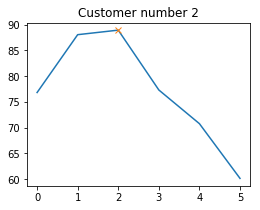

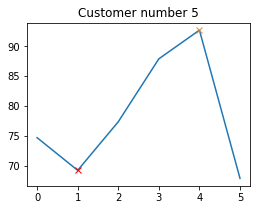

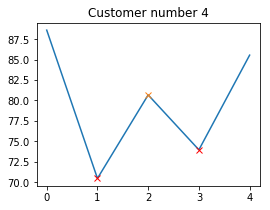

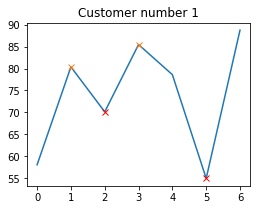

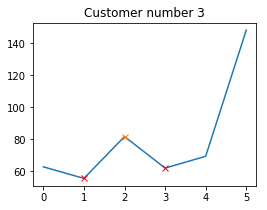

In [27]:
# make a plot per customer, with local minima and
# maxima of amount spent per hr

for customer in data['customer_id'].unique():
    tmp = data[data['customer_id']==customer]
    tmp = tmp.groupby('hr')['amount'].mean()
    tmp.reset_index(drop=True, inplace=True)
    find_and_plot_peaks(tmp, customer)


In [28]:
# create a series of functions to find the local maxima and minima
# put the arrays together, and then slice the original series into
# those values, to finally calculate the time elapsed between them

# these functions operate at a pandas series level
# x is a pandas series

def find_no_peaks(x):
    # finds number of local maxima
    peaks, _ = find_peaks(x)
    return peaks

def find_no_valleys(x):
    # finds number of local minima
    valleys, _ = find_peaks(1/x)
    return valleys

def concatenate_pav(x):
    # concatenates the indeces of the peaks and valleys
    ids = np.concatenate([find_no_peaks(x), find_no_valleys(x)])
    ids.sort()
    return ids

def slice_and_measure(x):
    # selects the points with peaks and valleys in the series
    # and determines the hr difference between them.
    # finally, returns the mean distance between
    # all local maxima and minima
    ids = concatenate_pav(x)
    tmp = pd.DataFrame(x.iloc[ids]).reset_index(drop=False)
    t = tmp['hr'].diff()
    return t.mean(skipna=True)

In [29]:
# this pandas series, df, is the argument we need for the
# precedent functions

# we use the data of customer 3 as an example to test each
# individual function

df = data[data['customer_id'] == 3]
df = df.groupby('hr')['amount'].mean()
df

hr
1     62.791333
4     55.579412
5     81.747500
6     62.019333
8     69.403939
9    148.310000
Name: amount, dtype: float64

In [30]:
# test function that finds number of peaks
peaks = find_no_peaks(df)
peaks

array([2], dtype=int64)

In [31]:
# test function that finds number of valleys
valleys = find_no_valleys(df)
valleys

array([1, 3], dtype=int64)

In [32]:
# test concatenate function

ids = concatenate_pav(df)
ids

array([1, 2, 3], dtype=int64)

In [33]:
# test result of concatenate_pav when applied to the
# entire dataset: that would be the indeces with max and min
# transaction amount per customer

data.groupby(['customer_id', 'hr'])['amount'].mean().groupby('customer_id').apply(concatenate_pav)

customer_id
1    [1, 2, 3, 5]
2             [2]
3       [1, 2, 3]
4       [1, 2, 3]
5          [1, 4]
Name: amount, dtype: object

In [34]:
# step by step the inner code of the function slide_and_measure()

tmp = pd.DataFrame(df.iloc[ids]).reset_index(drop=False)
t = tmp['hr'].diff()
t

0    NaN
1    1.0
2    1.0
Name: hr, dtype: float64

In [35]:
# output of slide_and_measure()

t.mean(skipna=True)

1.0

In [36]:
# test slide_and_measure() on 1 customer
slice_and_measure(df)

1.0

In [37]:
# apply slide_and_measure() to the entire data set

data.groupby(['customer_id', 'hr'])['amount'].mean().groupby(
    'customer_id').apply(slice_and_measure)

customer_id
1    1.666667
2         NaN
3    1.000000
4    1.000000
5    3.000000
Name: amount, dtype: float64

Compare the distances returned by our function with the peak distances in the plots in cell **23**.

Customer 2 shows np.nan, because it only contains 1 local maxima, so it is not possible to calculate distances.